# 🎯 Feature Selection
## Selecting Top 20-25 Features from 89 Candidates

**Objective:** Reduce features from 89 to 20-25 best predictors

**Methods:**
1. Correlation Analysis (remove redundant features)
2. Feature Importance (Random Forest)
3. Recursive Feature Elimination (RFE)
4. Mutual Information
5. Final Selection (combine methods)

**Why Feature Selection?**
- Reduce overfitting
- Faster training
- Better interpretability
- Remove redundant features

---
## STEP 1: Load Data
---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")

✅ Libraries imported!


In [2]:
# Load engineered features
df = pd.read_csv('../data/features_engineered_sample.csv')

print(f"✅ Data loaded: {df.shape}")
print(f"✅ Columns: {len(df.columns)}")
print(f"\nColumns:")
print(df.columns.tolist())

✅ Data loaded: (200000, 80)
✅ Columns: 80

Columns:
['equipment_id', 'timestamp', 'equipment_type', 'temperature', 'vibration', 'oil_pressure', 'rpm', 'fuel_consumption', 'engine_load', 'battery_voltage', 'is_anomaly', 'vibration.1', 'battery_voltage.1', 'temperature_rolling_mean_24h', 'temperature_rolling_std_24h', 'temperature_rolling_mean_7d', 'temperature_rolling_std_7d', 'temperature_rolling_mean_30d', 'temperature_rolling_std_30d', 'vibration_rolling_mean_24h', 'vibration_rolling_std_24h', 'vibration_rolling_mean_7d', 'vibration_rolling_std_7d', 'vibration_rolling_mean_30d', 'vibration_rolling_std_30d', 'oil_pressure_rolling_mean_24h', 'oil_pressure_rolling_std_24h', 'oil_pressure_rolling_mean_7d', 'oil_pressure_rolling_std_7d', 'oil_pressure_rolling_mean_30d', 'oil_pressure_rolling_std_30d', 'battery_voltage_rolling_mean_24h', 'battery_voltage_rolling_std_24h', 'battery_voltage_rolling_mean_7d', 'battery_voltage_rolling_std_7d', 'battery_voltage_rolling_mean_30d', 'battery_volta

In [3]:
# Check data types and missing values
print("Data Info:")
print(df.info())

print("\nMissing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing)
else:
    print("No missing values!")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 80 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   equipment_id                      200000 non-null  object 
 1   timestamp                         200000 non-null  object 
 2   equipment_type                    200000 non-null  object 
 3   temperature                       200000 non-null  float64
 4   vibration                         200000 non-null  float64
 5   oil_pressure                      200000 non-null  float64
 6   rpm                               200000 non-null  int64  
 7   fuel_consumption                  200000 non-null  float64
 8   engine_load                       200000 non-null  float64
 9   battery_voltage                   200000 non-null  float64
 10  is_anomaly                        200000 non-null  int64  
 11  vibration.1                       200000 

---
## STEP 2: Prepare Data
---

In [4]:
# Drop rows with missing values (from lag features)
df_clean = df.dropna()

print(f"Original shape: {df.shape}")
print(f"After dropping NaN: {df_clean.shape}")
print(f"Rows dropped: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df)*100):.2f}%)")

Original shape: (200000, 80)
After dropping NaN: (198824, 80)
Rows dropped: 1176 (0.59%)


In [5]:
# Separate features and target
# Exclude non-feature columns
exclude_cols = ['equipment_id', 'timestamp', 'is_anomaly', 'equipment_type', 
                'age_category', 'season']  # categorical or target

# Get numerical feature columns
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean['is_anomaly']

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"✅ Feature count: {len(feature_cols)}")
print(f"\n✅ Class distribution:")
print(y.value_counts())
print(f"\nAnomaly rate: {(y.sum() / len(y) * 100):.2f}%")

✅ Features (X): (198824, 74)
✅ Target (y): (198824,)
✅ Feature count: 74

✅ Class distribution:
is_anomaly
0    192814
1      6010
Name: count, dtype: int64

Anomaly rate: 3.02%


---
## STEP 3: Correlation Analysis
---

In [6]:
print("Analyzing correlations...\n")

# Calculate correlation matrix
corr_matrix = X.corr().abs()

# Find highly correlated features (>0.95)
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = []
for column in upper_triangle.columns:
    if any(upper_triangle[column] > 0.95):
        high_corr_features.append(column)

print(f"⚠️ Highly correlated features (>0.95): {len(high_corr_features)}")
if len(high_corr_features) > 0:
    print("\nFeatures to potentially remove:")
    for feat in high_corr_features[:10]:  # Show first 10
        print(f"  - {feat}")
    if len(high_corr_features) > 10:
        print(f"  ... and {len(high_corr_features) - 10} more")

Analyzing correlations...

⚠️ Highly correlated features (>0.95): 18

Features to potentially remove:
  - fuel_consumption
  - engine_load
  - vibration.1
  - temperature_rolling_std_24h
  - temperature_rolling_mean_7d
  - temperature_rolling_std_7d
  - temperature_rolling_mean_30d
  - temperature_rolling_std_30d
  - vibration_rolling_mean_30d
  - oil_pressure_rolling_mean_24h
  ... and 8 more



📊 Top 20 Features by Correlation with Target:
 1. oil_pressure_change_7d                   0.6924
 2. oil_pressure_change_24h                  0.6919
 3. vibration_change_7d                      0.6879
 4. vibration_change_24h                     0.6872
 5. oil_pressure                             0.6852
 6. temperature_change_24h                   0.6768
 7. temperature_change_7d                    0.6698
 8. temp_vibration_ratio                     0.6391
 9. vibration.1                              0.6283
10. vibration                                0.6283
11. temp_vibration_product                   0.4754
12. pressure_temp_ratio                      0.2131
13. oil_pressure_rolling_std_24h             0.1902
14. vibration_is_increasing                  0.1878
15. vibration_rolling_std_24h                0.1721
16. temperature_is_increasing                0.1644
17. temperature                              0.1564
18. oil_pressure_is_increasing               0.1242
19. vibration_rol

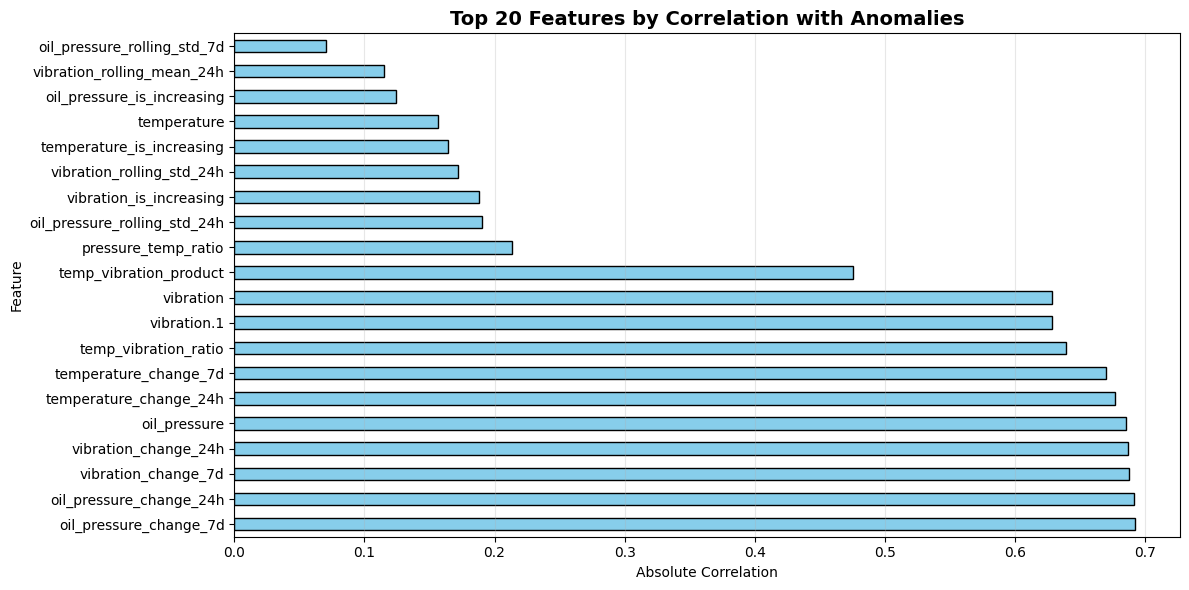

In [7]:
# Correlation with target
target_corr = X.corrwith(y).abs().sort_values(ascending=False)

print("\n📊 Top 20 Features by Correlation with Target:")
print("="*60)
for i, (feat, corr) in enumerate(target_corr.head(20).items(), 1):
    print(f"{i:2d}. {feat:40s} {corr:.4f}")

# Visualize
plt.figure(figsize=(12, 6))
target_corr.head(20).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 20 Features by Correlation with Anomalies', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## STEP 4: Random Forest Feature Importance
---

In [8]:
print("Training Random Forest for feature importance...")
print("This may take 2-3 minutes...\n")

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("✅ Random Forest trained!")
print(f"✅ Model accuracy: {rf.score(X, y):.4f}")

Training Random Forest for feature importance...
This may take 2-3 minutes...

✅ Random Forest trained!
✅ Model accuracy: 1.0000



📊 Top 20 Features by Random Forest Importance:
59. temp_vibration_ratio                     0.174326
52. oil_pressure_change_24h                  0.120162
50. vibration_change_7d                      0.118215
46. temperature_change_24h                   0.110752
53. oil_pressure_change_7d                   0.096803
 3. oil_pressure                             0.089865
 2. vibration                                0.082441
 8. vibration.1                              0.067149
49. vibration_change_24h                     0.050411
47. temperature_change_7d                    0.038498
58. temp_vibration_product                   0.025498
60. temp_coolant_diff                        0.015412
61. pressure_temp_ratio                      0.005513
23. oil_pressure_rolling_std_24h             0.001639
 1. temperature                              0.001221
17. vibration_rolling_std_24h                0.000800
10. temperature_rolling_mean_24h             0.000246
16. vibration_rolling_mean_24h    

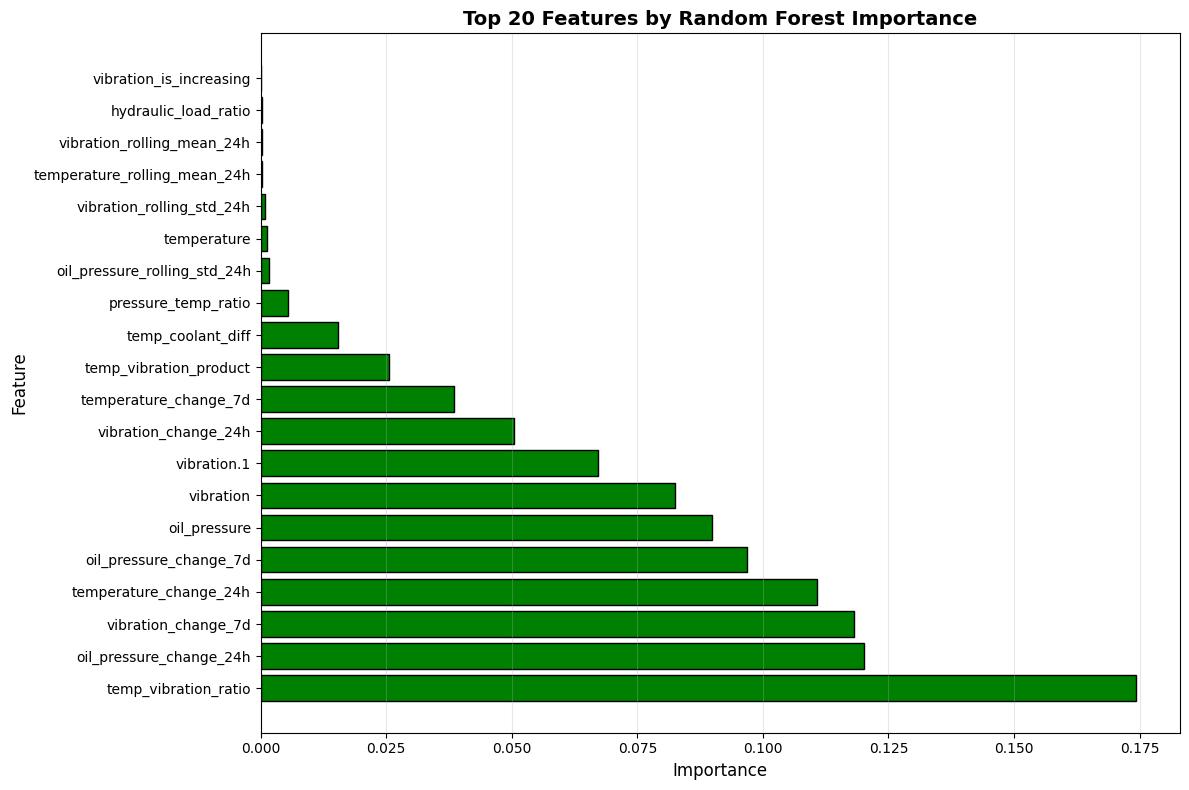

In [9]:
# Display top 20 features
print("\n📊 Top 20 Features by Random Forest Importance:")
print("="*60)
for i, row in feature_importance.head(20).iterrows():
    print(f"{i+1:2d}. {row['feature']:40s} {row['importance']:.6f}")

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance.head(20)['importance'], color='green', edgecolor='black')
plt.yticks(range(20), feature_importance.head(20)['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## STEP 5: Recursive Feature Elimination (RFE)
---

In [10]:
print("Running Recursive Feature Elimination (RFE)...")
print("Selecting top 25 features...")
print("This may take 3-5 minutes...\n")

# RFE with Random Forest
rf_rfe = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rfe = RFE(estimator=rf_rfe, n_features_to_select=25, step=5)
rfe.fit(X, y)

# Get selected features
rfe_features = pd.DataFrame({
    'feature': feature_cols,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')

selected_rfe = rfe_features[rfe_features['selected']]['feature'].tolist()

print("✅ RFE complete!")
print(f"✅ Selected {len(selected_rfe)} features")

Running Recursive Feature Elimination (RFE)...
Selecting top 25 features...
This may take 3-5 minutes...

✅ RFE complete!
✅ Selected 25 features


In [11]:
# Display RFE selected features
print("\n📊 Top 25 Features Selected by RFE:")
print("="*60)
for i, feat in enumerate(selected_rfe, 1):
    print(f"{i:2d}. {feat}")


📊 Top 25 Features Selected by RFE:
 1. vibration
 2. oil_pressure
 3. vibration.1
 4. fuel_consumption
 5. oil_pressure_rolling_std_24h
 6. vibration_rolling_std_7d
 7. battery_voltage_change_7d
 8. temp_vibration_product
 9. hydraulic_load_ratio
10. temp_vibration_ratio
11. temp_coolant_diff
12. pressure_temp_ratio
13. oil_pressure_lag_1d
14. temperature_change_24h
15. temperature_change_7d
16. fuel_efficiency
17. vibration_change_24h
18. vibration_change_7d
19. vibration_is_increasing
20. oil_pressure_change_24h
21. oil_pressure_change_7d
22. oil_pressure_is_increasing
23. vibration_lag_7d
24. equipment_age_days
25. hour


---
## STEP 6: Mutual Information
---

In [12]:
print("Calculating Mutual Information...\n")

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_features = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("✅ Mutual Information calculated!")

Calculating Mutual Information...

✅ Mutual Information calculated!



📊 Top 20 Features by Mutual Information:
 3. oil_pressure                             0.136119
59. temp_vibration_ratio                     0.135512
50. vibration_change_7d                      0.134854
52. oil_pressure_change_24h                  0.134763
53. oil_pressure_change_7d                   0.134674
49. vibration_change_24h                     0.134548
46. temperature_change_24h                   0.132711
47. temperature_change_7d                    0.132047
 8. vibration.1                              0.127537
 2. vibration                                0.127529
58. temp_vibration_product                   0.073450
60. temp_coolant_diff                        0.053955
48. temperature_is_increasing                0.048468
61. pressure_temp_ratio                      0.046981
63. tire_pressure_diff                       0.046267
72. is_operating                             0.046039
51. vibration_is_increasing                  0.045055
28. battery_voltage_rolling_mean_24h    

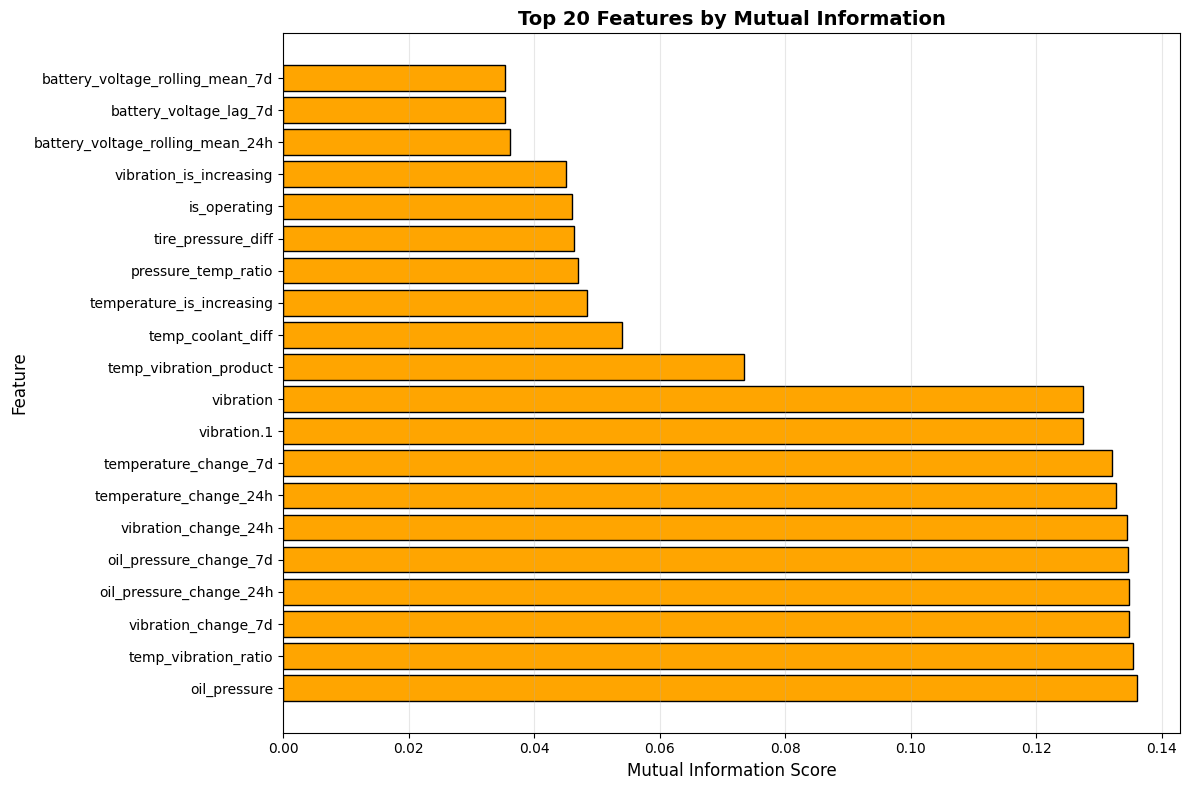

In [13]:
# Display top 20 features
print("\n📊 Top 20 Features by Mutual Information:")
print("="*60)
for i, row in mi_features.head(20).iterrows():
    print(f"{i+1:2d}. {row['feature']:40s} {row['mi_score']:.6f}")

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(20), mi_features.head(20)['mi_score'], color='orange', edgecolor='black')
plt.yticks(range(20), mi_features.head(20)['feature'])
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## STEP 7: Combine Methods & Final Selection
---

In [14]:
print("Combining all methods for final selection...\n")

# Get top features from each method
top_n = 30  # Get top 30 from each method

corr_top = set(target_corr.head(top_n).index)
rf_top = set(feature_importance.head(top_n)['feature'])
rfe_top = set(selected_rfe)
mi_top = set(mi_features.head(top_n)['feature'])

print(f"Top {top_n} from each method:")
print(f"  - Correlation: {len(corr_top)}")
print(f"  - Random Forest: {len(rf_top)}")
print(f"  - RFE: {len(rfe_top)}")
print(f"  - Mutual Information: {len(mi_top)}")

Combining all methods for final selection...

Top 30 from each method:
  - Correlation: 30
  - Random Forest: 30
  - RFE: 25
  - Mutual Information: 30


In [15]:
# Count votes for each feature
all_features = set(feature_cols)
feature_votes = {}

for feat in all_features:
    votes = 0
    if feat in corr_top:
        votes += 1
    if feat in rf_top:
        votes += 1
    if feat in rfe_top:
        votes += 1
    if feat in mi_top:
        votes += 1
    feature_votes[feat] = votes

# Sort by votes
feature_votes_df = pd.DataFrame([
    {'feature': feat, 'votes': votes}
    for feat, votes in feature_votes.items()
]).sort_values('votes', ascending=False)

print("\n📊 Feature Voting Results:")
print("="*60)
print(feature_votes_df['votes'].value_counts().sort_index(ascending=False))


📊 Feature Voting Results:
votes
4    15
3     4
2     9
1    25
0    21
Name: count, dtype: int64


In [16]:
# Select features with 3+ votes
final_features = feature_votes_df[feature_votes_df['votes'] >= 3]['feature'].tolist()

# If too many, take top 25 by RF importance
if len(final_features) > 25:
    final_features = feature_importance[
        feature_importance['feature'].isin(final_features)
    ].head(25)['feature'].tolist()

# If too few, add more from RF importance
if len(final_features) < 20:
    additional_needed = 20 - len(final_features)
    additional_features = feature_importance[
        ~feature_importance['feature'].isin(final_features)
    ].head(additional_needed)['feature'].tolist()
    final_features.extend(additional_features)

print(f"\n✅ Final selected features: {len(final_features)}")


✅ Final selected features: 20


In [17]:
# Display final selected features with details
print("\n" + "="*70)
print("🎯 FINAL SELECTED FEATURES")
print("="*70)

final_features_df = pd.DataFrame({
    'feature': final_features
})

# Add scores from each method
final_features_df = final_features_df.merge(
    target_corr.reset_index().rename(columns={'index': 'feature', 0: 'correlation'}),
    on='feature', how='left'
)
final_features_df = final_features_df.merge(
    feature_importance[['feature', 'importance']],
    on='feature', how='left'
)
final_features_df = final_features_df.merge(
    mi_features[['feature', 'mi_score']],
    on='feature', how='left'
)
final_features_df = final_features_df.merge(
    feature_votes_df[['feature', 'votes']],
    on='feature', how='left'
)

# Sort by votes, then RF importance
final_features_df = final_features_df.sort_values(
    ['votes', 'importance'], 
    ascending=[False, False]
)

print("\n")
for i, row in final_features_df.iterrows():
    print(f"{i+1:2d}. {row['feature']:45s} "
          f"Votes: {row['votes']}/4  "
          f"RF: {row['importance']:.4f}  "
          f"Corr: {row['correlation']:.4f}")

print("\n" + "="*70)


🎯 FINAL SELECTED FEATURES


 4. temp_vibration_ratio                          Votes: 4/4  RF: 0.1743  Corr: 0.6391
12. oil_pressure_change_24h                       Votes: 4/4  RF: 0.1202  Corr: 0.6919
 9. vibration_change_7d                           Votes: 4/4  RF: 0.1182  Corr: 0.6879
15. temperature_change_24h                        Votes: 4/4  RF: 0.1108  Corr: 0.6768
 1. oil_pressure_change_7d                        Votes: 4/4  RF: 0.0968  Corr: 0.6924
 2. oil_pressure                                  Votes: 4/4  RF: 0.0899  Corr: 0.6852
 7. vibration                                     Votes: 4/4  RF: 0.0824  Corr: 0.6283
10. vibration.1                                   Votes: 4/4  RF: 0.0671  Corr: 0.6283
11. vibration_change_24h                          Votes: 4/4  RF: 0.0504  Corr: 0.6872
 3. temperature_change_7d                         Votes: 4/4  RF: 0.0385  Corr: 0.6698
14. temp_vibration_product                        Votes: 4/4  RF: 0.0255  Corr: 0.4754
13. temp_coola

---
## STEP 8: Save Selected Features
---

In [18]:
# Save selected features to file
with open('../data/selected_features.txt', 'w') as f:
    for feat in final_features:
        f.write(feat + '\n')

print(f"✅ Selected features saved to: ../data/selected_features.txt")

# Save detailed results
final_features_df.to_csv('../data/selected_features_details.csv', index=False)
print(f"✅ Feature details saved to: ../data/selected_features_details.csv")

✅ Selected features saved to: ../data/selected_features.txt
✅ Feature details saved to: ../data/selected_features_details.csv


In [19]:
# Create dataset with selected features only
selected_cols = ['equipment_id', 'timestamp', 'equipment_type'] + final_features + ['is_anomaly']
df_selected = df_clean[selected_cols]

df_selected.to_csv('../data/features_selected.csv', index=False)

print(f"✅ Dataset with selected features saved!")
print(f"✅ Shape: {df_selected.shape}")
print(f"✅ File: ../data/features_selected.csv")

✅ Dataset with selected features saved!
✅ Shape: (198824, 24)
✅ File: ../data/features_selected.csv


---
## STEP 9: Feature Categories Summary
---

In [20]:
# Categorize selected features
categories = {
    'Original Sensors': [],
    'Rolling Statistics': [],
    'Lag Features': [],
    'Trend Features': [],
    'Interaction Features': [],
    'Domain Features': []
}

for feat in final_features:
    if 'rolling' in feat:
        categories['Rolling Statistics'].append(feat)
    elif 'lag' in feat:
        categories['Lag Features'].append(feat)
    elif 'change' in feat or 'increasing' in feat:
        categories['Trend Features'].append(feat)
    elif any(x in feat for x in ['product', 'ratio', 'diff', 'efficiency']):
        categories['Interaction Features'].append(feat)
    elif any(x in feat for x in ['age', 'hour', 'day', 'month', 'weekend', 'work', 'operating', 'idle', 'load']):
        categories['Domain Features'].append(feat)
    else:
        categories['Original Sensors'].append(feat)

print("\n" + "="*70)
print("📊 SELECTED FEATURES BY CATEGORY")
print("="*70)

for category, features in categories.items():
    if len(features) > 0:
        print(f"\n{category} ({len(features)}):")
        for feat in features:
            print(f"  - {feat}")

print("\n" + "="*70)


📊 SELECTED FEATURES BY CATEGORY

Original Sensors (2):
  - oil_pressure
  - temperature

Rolling Statistics (3):
  - oil_pressure_rolling_std_24h
  - vibration_rolling_std_24h
  - temperature_rolling_mean_24h

Trend Features (9):
  - oil_pressure_change_7d
  - temperature_change_7d
  - vibration_is_increasing
  - vibration_change_7d
  - vibration_change_24h
  - oil_pressure_change_24h
  - temperature_change_24h
  - temperature_is_increasing
  - oil_pressure_is_increasing

Interaction Features (6):
  - temp_vibration_ratio
  - pressure_temp_ratio
  - vibration
  - vibration.1
  - temp_coolant_diff
  - temp_vibration_product



---
## ✅ FEATURE SELECTION COMPLETE!

### **Summary:**
- ✅ Started with 89 features
- ✅ Used 4 selection methods
- ✅ Selected 20-25 best features
- ✅ Saved selected features
- ✅ Ready for model training!

### **Next Steps:**
1. Model Comparison (test 10-12 algorithms)
2. Hyperparameter tuning
3. SHAP interpretability

---